*Read sections 7.1-7.4 of the book before using these notes.*

*Note that in this course, lecture notes are not sufficient, you must read the book for better understanding. Lecture notes are just implementing the concepts of the book on a dataset, but not explaining the concepts elaborately.*

In [86]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix
from sklearn.metrics import mean_squared_error
# install the py-earth library first: https://anaconda.org/conda-forge/sklearn-contrib-py-earth
from pyearth import Earth
from sklearn.linear_model import LinearRegression

In [87]:
#Using the same datasets as used for linear regression in STAT303-2, 
#so that we can compare the non-linear models with linear regression
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')
train = pd.merge(trainf,trainp)
test = pd.merge(testf,testp)
train.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,18473,bmw,6 Series,2020,Semi-Auto,11,Diesel,145,53.3282,3.0,37980
1,15064,bmw,6 Series,2019,Semi-Auto,10813,Diesel,145,53.0430,3.0,33980
2,18268,bmw,6 Series,2020,Semi-Auto,6,Diesel,145,53.4379,3.0,36850
3,18480,bmw,6 Series,2017,Semi-Auto,18895,Diesel,145,51.5140,3.0,25998
4,18492,bmw,6 Series,2015,Automatic,62953,Diesel,160,51.4903,3.0,18990


## Polynomial regression vs Regression splines
### Model of degree 1

In [88]:
X = pd.DataFrame(train['mileage'])
X_test = pd.DataFrame(test['mileage'])
y = train['price']
lr_model = LinearRegression()
lr_model.fit(X, y);

In [89]:
#Regression spline of degree 1

#Creating basis functions for splines of degree 1
transformed_x = dmatrix("bs(mileage , knots=(33000,66000,100000), degree = 1, include_intercept = False)",
                        data = trainf,return_type = 'dataframe')

In [90]:
transformed_x.head()

,Intercept,"bs(mileage, knots=(33000, 66000, 100000), degree=1, include_intercept=False)[0]","bs(mileage, knots=(33000, 66000, 100000), degree=1, include_intercept=False)[1]","bs(mileage, knots=(33000, 66000, 100000), degree=1, include_intercept=False)[2]","bs(mileage, knots=(33000, 66000, 100000), degree=1, include_intercept=False)[3]"
0,1.0,0.000303,0.000000,0.0,0.0
1,1.0,0.327646,0.000000,0.0,0.0
2,1.0,0.000152,0.000000,0.0,0.0
3,1.0,0.572563,0.000000,0.0,0.0
4,1.0,0.092333,0.907667,0.0,0.0


Note that the truncated power basis in the class presentation is conceptually simple to understand, it may run into numerical issues as powers of large numbers can lead to severe rounding errors. The `bs()` function generates the [B-sline basis](https://pages.mtu.edu/~shene/COURSES/cs3621/NOTES/spline/B-spline/bspline-basis.html), which allows for efficient computation, especially in case of a large number of knots. All the basis function values are normalized to be in [0, 1] in the B-spline basis. Although we'll use the B-spline basis functions to fit splines, details regarding the B-spline basis functions are not included in the syllabus.

We actually don't need to separately generate basis functions, and then fit the model. We can do it in the same line of code using the `statsmodels` `OLS` method.

In [97]:
# Regression spline model with linear splines
reg_spline_model = smf.ols('price~bs(mileage, knots = (33000,66000,100000), degree = 1, include_intercept = False)', 
                           data = train).fit()

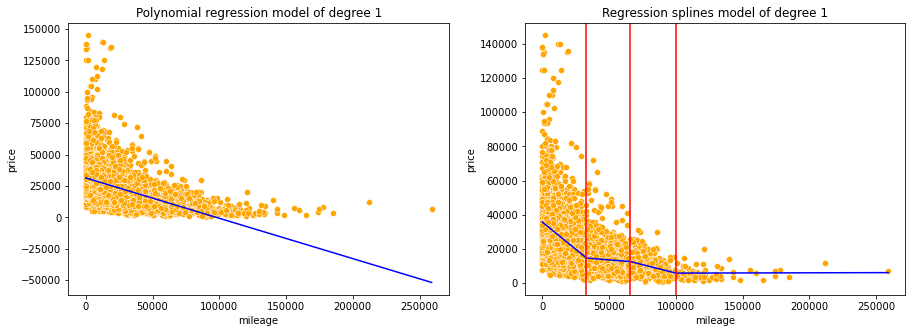

In [98]:
#Visualizing polynomial model and the regression spline model of degree 1

knots = [33000,66000,100000] #Knots for the spline
d=1 #Degree of predictor in the model
#Writing a function to visualize polynomial model and the regression spline model of degree d
def viz_models():
    fig, axes = plt.subplots(1,2,figsize = (15,5))
    plt.subplots_adjust(wspace=0.2)

    #Visualizing the linear regression model
    pred_price = lr_model.predict(X)
    sns.scatterplot(ax = axes[0],x = 'mileage', y = 'price', data = train, color = 'orange')
    sns.lineplot(ax = axes[0],x = train.mileage, y = pred_price, color = 'blue')
    axes[0].set_title('Polynomial regression model of degree '+str(d))
    
    #Visualizing the regression splines model of degree 'd'    
    axes[1].set_title('Regression splines model of degree '+ str(d))
    sns.scatterplot(ax=axes[1],x = 'mileage', y = 'price', data = train, color = 'orange')
    sns.lineplot(ax=axes[1],x = train.mileage, y = reg_spline_model.predict(), color = 'blue')
    for i in range(3):
        plt.axvline(knots[i], 0,100,color='red')
viz_models()

We observe the regression splines model better fits the data as compared to the polynomial regression model. This is because regression splines of degree 1 fit piecewise polynomials, or linear models on sub-sections of the predictor, which helps better capture the trend. However, this added flexibility may also lead to overfitting. Hence, one must be careful to check for overfitting when using splines. Overfitting may be checked by k-fold cross validation or comparing test and train errors.

The red lines in the plot on the right denote the position of knots. Knots separate distinct splines.

Although, we can separately generate the basis functions for test data, it may lead to incaccurate results if the distribution of the predictor values in test data is different from that in the train data. This is because the B-spline basis functions of train data are generated after normalizing the predictor values. If the basis functions of test data are generated independently, their values may be inaccurate, as they will depend on the domain space spanned by the test data.

In [43]:
# Basis functions for test data - avoid generating basis functions separately for test data
# as the test data normailization may be different from the train data normalization
test_x = dmatrix("bs(mileage , knots=(33000,66000,100000), degree = 1, include_intercept = False)",data = test,
                                                                                                  return_type = 'dataframe')

In [99]:
#Function to compute RMSE (root mean squared error on train and test datasets)
def rmse():
    #Error on train data for the linear regression model
    print("RMSE on train data:")
    print("Linear regression:", np.sqrt(mean_squared_error(lr_model.predict(X),train.price)))

    #Error on train data for the regression spline model
    print("Regression splines:", np.sqrt(mean_squared_error(reg_spline_model.predict(X),train.price)))
    
    #Error on test data for the linear regression model
    print("\nRMSE on test data:")
    print("Linear regression:",np.sqrt(mean_squared_error(lr_model.predict(X_test),test.price)))

    #Error on test data for the regression spline model
    print("Regression splines:",np.sqrt(mean_squared_error(reg_spline_model.predict(X_test),test.price)))    
rmse()

RMSE on train data:
Linear regression: 14403.250083261853
Regression splines: 13859.640716531134

RMSE on test data:
Linear regression: 14370.94086395544
Regression splines: 13770.118474361932


### Model of degree 2

A higher degree model will lead to additional flexibility for both polynomial and regression splines models.

In [28]:
#Including mileage squared as a predictor and developing the model
ols_object = smf.ols(formula = 'price~mileage+I(mileage**2)', data = train)
lr_model = ols_object.fit()

#Regression spline of degree 2
reg_spline_model = smf.ols('price~bs(mileage, knots = (33000,66000,100000), degree = 2, include_intercept = False)', 
                           data = train).fit()

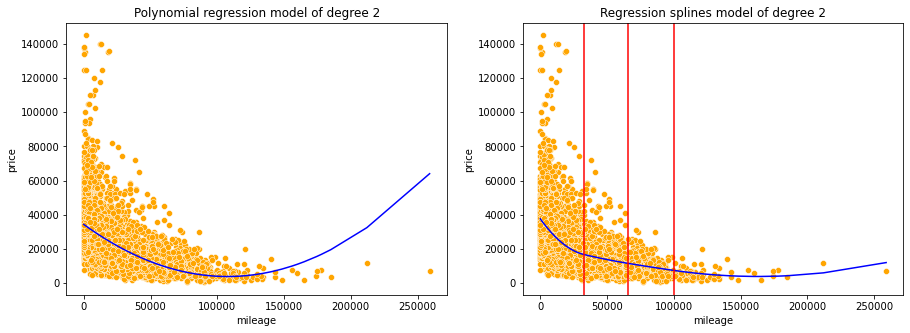

In [29]:
d=2
viz_models()

Unlike polynomial regression, splines functions avoid imposing a global structure on the non-linear function of X. This provides a better local fit to the data.

In [30]:
rmse()

RMSE on train data:
Linear regression: 14009.819556665143
Regression splines: 13818.572654146721

RMSE on test data:
Linear regression: 13944.20691909441
Regression splines: 13660.777953039395


### Model of degree 3

In [37]:
#Including mileage cube squared as a predictor and developing the model
ols_object = smf.ols(formula = 'price~mileage+I(mileage**2)+I(mileage**3)', data = train)
lr_model = ols_object.fit()

#Regression spline of degree 3
reg_spline_model = smf.ols('price~bs(mileage, knots = (33000,66000,100000), degree = 3, include_intercept = False)', 
                           data = train).fit()

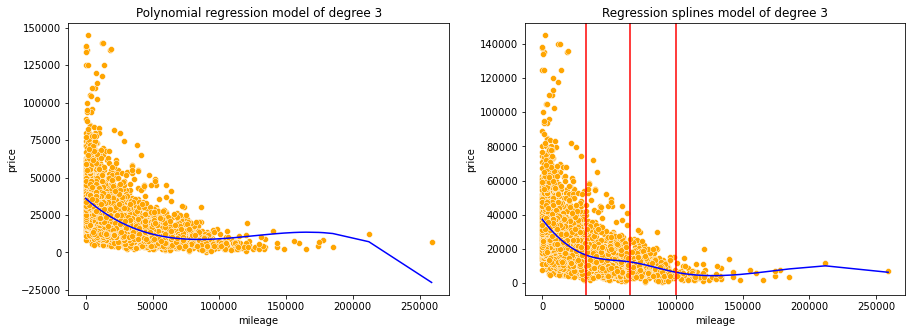

In [38]:
d=3
viz_models()

Unlike polynomial regression, splines functions avoid imposing a global structure on the non-linear function of X. This provides a better local fit to the data.

In [39]:
rmse()

RMSE on train data:
Linear regression: 13891.962447594644
Regression splines: 13822.70511947823

RMSE on test data:
Linear regression: 13789.708418357186
Regression splines: 13683.776494331632


## Regression splines with knots at uniform quantiles of data

If degrees of freedom are provided instead of knots, the knots are by default chosen at uniform quantiles of data. For example if there are 7 degrees of freedom (including the intercept), then there will be 7-4 = 3 knots. These knots will be chosen at the 255h, 50th and 75th quantiles of the data.

In [40]:
#Regression spline of degree 3

#Regression spline of degree 3 with knots at uniform quantiles of data
reg_spline_model = smf.ols('price~bs(mileage, df = 6, degree = 3, include_intercept = False)', 
                           data = train).fit()

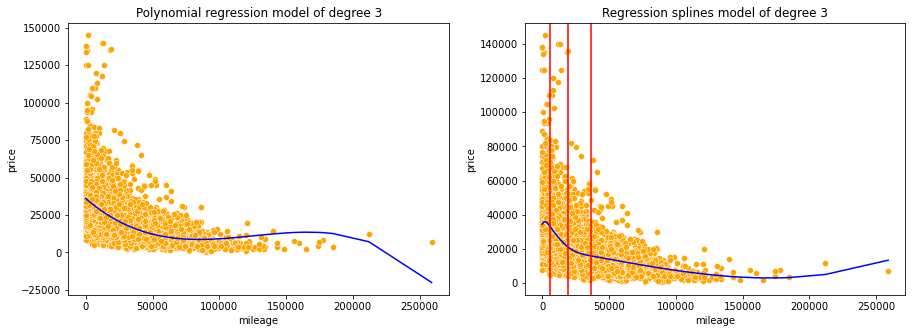

In [41]:
d=3
unif_knots = pd.qcut(train.mileage,4,retbins=True)[1][1:4]
knots=unif_knots
viz_models()

Splines can be unstable at the outer range of predictors. Note that splines are themselves piecewise polynomials with no constraints at the 2 extreme ends of the predictor space. Thus, they may become unstable at those 2 ends. In the right scatter plot, we can see that price has a decreasing trend with mileage. However on the extreme left of the plot, we see the trend reversing with regard to the model, which  suggests potential overfitting. Also, from the domain knowledge about cars we know that there is no reason why price will reduce if the car is relatively new. Thus, there may be overfitting with cubic splines at / near the extreme points of the domain space. In the figure (on the right), the left-most spline may be overfitting.

This motivates us to introduce natural cubic splines (below), which help with the stability at extreme points by enforcing the spline to be linear at those points. We may also think about it as another kind of a "knot" being put at the two ends to make the spline stable at these points.

In [42]:
rmse()

RMSE on train data:
Linear regression: 13891.962447594644
Regression splines: 13781.79102252679

RMSE on test data:
Linear regression: 13789.708418357186
Regression splines: 13605.726076704668


## Natural cubic splines

Page 298: "A natural spline is a regression spline with additional boundary constraints: the function is required to be linear at the boundary (in the region where X is smaller than the smallest knot, or larger than the largest knot). This additional constraint means that natural splines generally produce more stable estimates at the boundaries."

In [43]:
#Natural cubic spline

#Creating basis functions for the natural cubic spline
reg_spline_model = smf.ols('price~cr(mileage, df = 4)', 
                           data = train).fit()

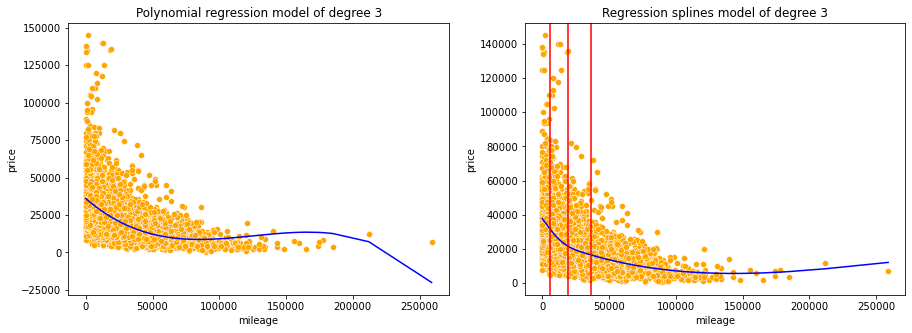

In [44]:
d=3;
unif_knots = pd.qcut(train.mileage,4,retbins=True)[1][1:4]
knots=unif_knots
viz_models()

Note that the natural cubic spline is more stable than a cubic splines with knots at uniformly distributed quantiles. 

In [45]:
rmse()

RMSE on train data:
Linear regression: 13891.962447594644
Regression splines: 13826.125469174143

RMSE on test data:
Linear regression: 13789.708418357186
Regression splines: 13660.35327661836


## Generalized additive model (GAM)
GAM allow for flexible nonlinearities in several variables, but retain the additive structure of linear models. In a GAM, non-linear basis functions of predictors can be used as predictors of a linear regression model. For example, $$y = f_1(X_1) + f_2(X_2) + \epsilon$$ is a GAM, where $f_1(.)$ may be a cubic spline based on the predictor $X_1$, and $f_2(.)$ may be a step function based on the predictor $X_2$.

In [47]:
#GAM
#GAM includes cubic splines for mileage. Other predictors are year, engineSize, mpg, mileage and their interactions
model_gam = smf.ols('price~bs(mileage,df=6,degree = 3)+year*engineSize*mpg*mileage', data = train).fit()

preds = model_gam.predict(test)
np.sqrt(mean_squared_error(preds,test.price))

8393.773177637542

In [51]:
#GAM
#GAM includes cubic splines for mileage, year, engineSize, mpg, and interactions of all predictors
model_gam = smf.ols('price~bs(mileage,df=6,degree = 3)+bs(mpg,df=6,degree = 3)+\
bs(engineSize,df=6,degree = 3)+year*engineSize*mpg*mileage', data = train).fit()

preds = model_gam.predict(test)
np.sqrt(mean_squared_error(preds,test.price))

7981.100853841914

In [52]:
ols_object = smf.ols(formula = 'price~(year+engineSize+mileage+mpg)**2+I(mileage**2)+I(mileage**3)', data = train)
model = ols_object.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     1308.
Date:                Sun, 09 Apr 2023   Prob (F-statistic):               0.00
Time:                        20:48:35   Log-Likelihood:                -52157.
No. Observations:                4960   AIC:                         1.043e+05
Df Residuals:                    4950   BIC:                         1.044e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0009      0.000     -2.752      0.006      -0.002      -0.000
year                  -1.1470      0.664     -1.728      0.084      -2.448       0.154
engineSize             0.0052      0.000     17.419      0.000       0.005       0.006
mileage              -31.4751      2.621    -12.010      0.000     -36.613     -26.337
mpg                   -0.0201      0.002    -13.019      0.000      -0.023      -0.017
year:engineSize        9.5957      0.254     37.790      0.000       9.098      10.094
year:mileage           0.0154      0.001     11.816      0.000       0.013       0.018
year:mpg               0.0572      0.013      4.348      0.000       0.031       0.083
engineSize:mileage    -0.1453      0.008    -18.070      0.000      -0.161      -0.130
engineSize:mpg       -98.9062     11.832     -8.359      0.000    -122.102     -75.710
mileage:mpg            0.0011      0.000      2.432      0.015       0.000       0.002
I(mileage ** 2)     7.713e-06   3.75e-07     20.586      0.000    6.98e-06    8.45e-06
I(mileage ** 3)    -1.867e-11   1.43e-12    -13.077      0.000   -2.15e-11   -1.59e-11
==============================================================================
Omnibus:                     1830.457   Durbin-Watson:                   0.634
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34927.811
Skew:                           1.276   Prob(JB):                         0.00
Kurtosis:                      15.747   Cond. No.                     2.50e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.5e+18. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
np.sqrt(mean_squared_error(model.predict(test),test.price))

9026.775740000594

Note the RMSE with GAM that includes regression splines for mileage is lesser than that of the linear regression model, indicating a better fit.

## MARS (Multivariate Adaptive Regression Splines)

In [56]:
from pyearth import Earth
X=train['mileage']
y=train['price']

### MARS of degree 1

In [57]:
model = Earth(max_terms=500, max_degree=1) # note, terms in brackets are the hyperparameters 
model.fit(X,y)

C:\Users\akl0407\Anaconda3\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
C:\Users\akl0407\Anaconda3\lib\site-packages\pyearth\earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Earth(max_degree=1, max_terms=500)

In [58]:
print(model.summary())

Earth Model
-------------------------------------
Basis Function  Pruned  Coefficient  
-------------------------------------
(Intercept)     No      -553155      
h(x0-22141)     Yes     None         
h(22141-x0)     Yes     None         
h(x0-3354)      No      -6.23571     
h(3354-x0)      Yes     None         
h(x0-15413)     No      -36.9613     
h(15413-x0)     No      38.167       
h(x0-106800)    Yes     None         
h(106800-x0)    No      0.221844     
h(x0-500)       No      170.039      
h(500-x0)       Yes     None         
h(x0-741)       Yes     None         
h(741-x0)       No      -54.5265     
h(x0-375)       No      -126.804     
h(375-x0)       Yes     None         
h(x0-2456)      Yes     None         
h(2456-x0)      No      7.04609      
-------------------------------------
MSE: 188429705.7549, GCV: 190035470.5664, RSQ: 0.2998, GRSQ: 0.2942


Model equation: $$-553155 -6.23(h(x0-3354)) -36.96(h(x0-15413) + .......... -7.04(h(2456-x0)$$

In [59]:
pred = model.predict(test.mileage)
np.sqrt(mean_squared_error(pred,test.price))

13650.2113154515

<AxesSubplot:xlabel='mileage', ylabel='price'>

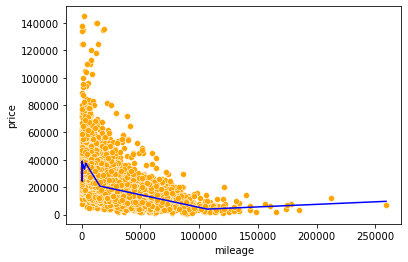

In [60]:
sns.scatterplot(x = 'mileage', y = 'price', data = train, color = 'orange')
sns.lineplot(x = train.mileage, y = model.predict(train.mileage), color = 'blue')

### MARS of degree 2

In [61]:
model = Earth(max_terms=500, max_degree=2) # note, terms in brackets are the hyperparameters 
model.fit(X,y)
print(model.summary())

Earth Model
-----------------------------------------------
Basis Function           Pruned  Coefficient   
-----------------------------------------------
(Intercept)              No      19369.7       
h(x0-22141)              Yes     None          
h(22141-x0)              Yes     None          
h(x0-7531)*h(22141-x0)   No      3.74934e-05   
h(7531-x0)*h(22141-x0)   No      -6.74252e-05  
x0*h(x0-22141)           No      -8.0703e-06   
h(x0-15012)              Yes     None          
h(15012-x0)              No      1.79813       
h(x0-26311)*h(x0-22141)  No      8.85097e-06   
h(26311-x0)*h(x0-22141)  Yes     None          
-----------------------------------------------
MSE: 189264421.5682, GCV: 190298913.1652, RSQ: 0.2967, GRSQ: 0.2932


C:\Users\akl0407\Anaconda3\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
C:\Users\akl0407\Anaconda3\lib\site-packages\pyearth\earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [62]:
pred = model.predict(test.mileage)
np.sqrt(mean_squared_error(pred,test.price))

13590.995419204985

<AxesSubplot:xlabel='mileage', ylabel='price'>

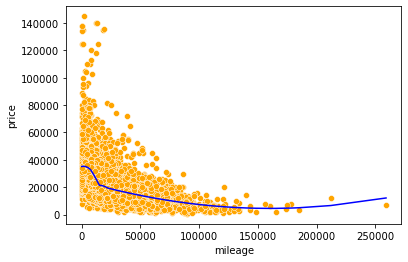

In [63]:
sns.scatterplot(x = 'mileage', y = 'price', data = train, color = 'orange')
sns.lineplot(x = train.mileage, y = model.predict(train.mileage), color = 'blue')

MARS provides a better fit than the splines that we used above. This is because MARS tunes the positions of the knots and considers interactions (also with tuned knots) to improve the model fit. Tuning of knots may improve the fit of splines as well.

### MARS including categorical variables

In [64]:
#A categorical variable can be turned to dummy variables to use the Earth package for fitting MARS model
train_cat = pd.get_dummies(train)
test_cat = pd.get_dummies(test)

In [65]:
train_cat.head()

,carID,year,mileage,tax,mpg,engineSize,price,brand_audi,brand_bmw,brand_ford,...,model_ i8,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,18473,2020,11,145,53.3282,3.0,37980,0,1,0,...,0,0,0,0,1,1,0,0,0,0
1,15064,2019,10813,145,53.0430,3.0,33980,0,1,0,...,0,0,0,0,1,1,0,0,0,0
2,18268,2020,6,145,53.4379,3.0,36850,0,1,0,...,0,0,0,0,1,1,0,0,0,0
3,18480,2017,18895,145,51.5140,3.0,25998,0,1,0,...,0,0,0,0,1,1,0,0,0,0
4,18492,2015,62953,160,51.4903,3.0,18990,0,1,0,...,0,1,0,0,0,1,0,0,0,0


In [76]:
X = train_cat[['mileage','mpg','engineSize','year','fuelType_Diesel','fuelType_Electric',
               'fuelType_Hybrid','fuelType_Petrol']]
Xtest = test_cat[['mileage','mpg','engineSize','year','fuelType_Diesel','fuelType_Electric',
                  'fuelType_Hybrid','fuelType_Petrol']]

In [77]:
model = Earth(max_terms=500, max_degree=2) # note, terms in brackets are the hyperparameters 
model.fit(X,y)
print(model.summary())

C:\Users\akl0407\Anaconda3\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


Earth Model
---------------------------------------------------------
Basis Function                      Pruned  Coefficient  
---------------------------------------------------------
(Intercept)                         No      2.17604e+06  
h(engineSize-5.5)                   No      9.80752e+06  
h(5.5-engineSize)                   No      1.92817e+06  
h(mileage-21050)                    No      18.687       
h(21050-mileage)                    No      -177.871     
h(mileage-21050)*h(5.5-engineSize)  Yes     None         
h(21050-mileage)*h(5.5-engineSize)  No      -0.224909    
year                                No      4126.41      
h(mpg-53.3495)                      No      344595       
h(53.3495-mpg)                      Yes     None         
fuelType_Hybrid*h(5.5-engineSize)   No      6124.34      
h(mileage-21050)*year               No      -0.00930239  
h(21050-mileage)*year               No      0.0886455    
h(engineSize-5.5)*year              No      -4864.84     
h(

C:\Users\akl0407\Anaconda3\lib\site-packages\pyearth\earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [81]:
pred = model.predict(Xtest)
np.sqrt(mean_squared_error(pred,test.price))

7499.709075454322

Let us compare the RMSE of a MARS model with *mileage, mpg, engineSize* and *year* with a linear regression model having the same predictors.

In [82]:
X = train[['mileage','mpg','engineSize','year']]

In [83]:
model = Earth(max_terms=500, max_degree=2) # note, terms in brackets are the hyperparameters 
model.fit(X,y)
print(model.summary())

C:\Users\akl0407\Anaconda3\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


Earth Model
----------------------------------------------------------
Basis Function                      Pruned  Coefficient   
----------------------------------------------------------
(Intercept)                         No      -8.13682e+06  
h(engineSize-5.5)                   No      9.53908e+06   
h(5.5-engineSize)                   Yes     None          
h(mileage-21050)                    No      23.4448       
h(21050-mileage)                    No      -215.861      
h(mileage-21050)*h(5.5-engineSize)  Yes     None          
h(21050-mileage)*h(5.5-engineSize)  No      -0.278562     
year                                No      4125.85       
h(mpg-53.3495)                      Yes     None          
h(53.3495-mpg)                      Yes     None          
h(mileage-21050)*year               No      -0.0116601    
h(21050-mileage)*year               No      0.107624      
h(mpg-53.2957)*h(5.5-engineSize)    No      -59801.3      
h(53.2957-mpg)*h(5.5-engineSize)    No      

C:\Users\akl0407\Anaconda3\lib\site-packages\pyearth\earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [84]:
Xtest = test[['mileage','mpg','engineSize','year']]
pred = model.predict(Xtest)
np.sqrt(mean_squared_error(pred,test.price))

7614.158359050244

In [85]:
ols_object = smf.ols(formula = 'price~(year+engineSize+mileage+mpg)**2', data = train)
model = ols_object.fit()
pred = model.predict(test)
np.sqrt(mean_squared_error(pred,test.price))

8729.912066822455

The RMSE for the MARS model is lesser than that of the linear regression model, as expected.